In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from astropy.io import fits
import numpy  as np
import pandas as pd
import h5py

from tqdm import tqdm
from astropy import units
from astropy import units as u
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from scipy.signal      import argrelextrema

import ehtplot
import matplotlib as mpl
from matplotlib import pyplot as plt, cm

plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif",
#    "font.serif": ["Palatino"],
#    'mathtext.fontset': 'custom',
#    'mathtext.rm': 'Bitstream Vera Sans',
#    'mathtext.it': 'Bitstream Vera Sans:italic',
#    'mathtext.bf': 'Bitstream Vera Sans:bold',   
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
})

from common import dalt
from common import hallmark as hm
from common import viz
from common import io_ipole as io
from common import mockservation as ms

from scipy import ndimage

In [2]:
img_avg = io.load_mov([f'model/Illinois_thermal/230GHz/Ma+0.5_w5/img_s05{i:03d}_Rh160_i30.h5'
                       for i in range(1000) # range(511,918)
                      ], mean=True)

In [3]:
img_avg.Fnu

<Quantity 2.24962266 Jy>

In [4]:
def mkimg(img):
    px = 79.52842452054078 * 200 / 400
    return dalt.Image(
        ndimage.rotate(img[::-1,:].T, 140, reshape=False) * 1.717906984151418,
        4.14e6 * u.Msun, 2.5077305106e+22 * u.cm, 86e9 * u.H, 0, px, px)  

img_weighted = mkimg(np.load('../temp/weighted.npy'))

In [5]:
np.sum(np.load('../temp/weighted.npy'))

1.788132053906231

In [6]:
img_weighted.Fnu

<Quantity 1.78813205 Jy>

In [7]:
with fits.open('data/reconst/avgimage.fits') as hdul:
    img_mock = dalt.Image(hdul[0].data.T, 4.14e6 * u.Msun, 2.5077305106e+22 * u.cm, 86e9 * u.H, 0, 79.52842452054078 * 150 / 400, 79.52842452054078 * 150 / 400)   
#fig, ax = plt.subplots(1,1)
#viz.show(img_mock, ax=ax, cmap='afmhot_10us')

In [8]:
with fits.open('data/reconst/hops_avg.fits') as hdul:
    img_obs = dalt.Image(hdul[0].data.T, 4.14e6 * u.Msun, 2.5077305106e+22 * u.cm, 86e9 * u.H, 0, 79.52842452054078 * 150 / 400, 79.52842452054078 * 150 / 400)   
#fig, ax = plt.subplots(1,1)
#viz.show(img_obs, ax=ax, cmap='afmhot_10us')

In [9]:
img_obs.Fnu

<Quantity 2.98631181 Jy>

In [10]:
from copy import copy

#20 FWMH

sigma = 20 / 2.355
a = np.linspace(-199.5,199.5,400)
b = np.linspace(-199.5,199.5,400)
a, b = np.meshgrid(a, b)
g = np.exp(-(a*a + b*b) / (2*sigma*sigma))
g /= np.sum(g)

def compress2(imgs, N=None): #, sigma=1/(168/2 * u.uas.to(u.rad))):
    meta = copy(imgs.meta)
    fov  = imgs.fov.to(units.rad).value
    
    spec, U, V = ms.upfft(imgs, *fov, N=N)
    G,    U, V = ms.upfft(g,    *fov, N=N)

    u = np.linspace(-U/2,U/2,spec.shape[-2],endpoint=False)
    v = np.linspace( 0,  V/2,spec.shape[-1])
    u, v = np.meshgrid(u, v, indexing='ij')

    #G  = np.exp(-(u*u + v*v) / (2 * np.pi * np.pi * sigma * sigma))
    
    I, W, H = ms.downifft(spec * G[np.newaxis,:,:], U, V)
    
    meta.width  = abs(W * meta.dist).to(meta.rg)
    meta.height = abs(H * meta.dist).to(meta.rg)
    return dalt.Image(I, meta=meta)

(400, 400) -> [400 400]
(400, 400) -> [400 400]
(400, 400) -> [400 400]


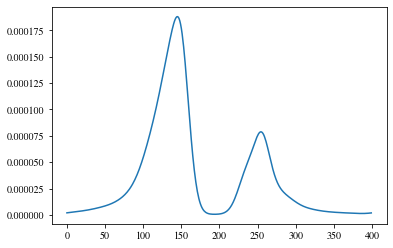

In [11]:
img_weighted_filtered = compress2(img_weighted)
plt.plot(img_weighted_filtered[0,200,:])

In [12]:
print(np.max(img_avg), np.max(img_weighted), np.max(img_mock), np.max(img_obs))

0.0006282294448503394 erg / (cm2 Hz s sr) 0.0005563308707510729 erg / (cm2 Hz s sr) 0.00024595101804100256 erg / (cm2 Hz s sr) 0.0002852638402558748 erg / (cm2 Hz s sr)


In [13]:
from astropy import constants as c

nu = 227070703125.0 * u.Hz # input image may have this information

scale = c.c**2 / (2 * c.k_B * nu**2) * u.rad**2

vmax = 15e9

Bbox(x0=0.70625, y0=0.21187500000000004, x1=0.9, y1=0.793125)


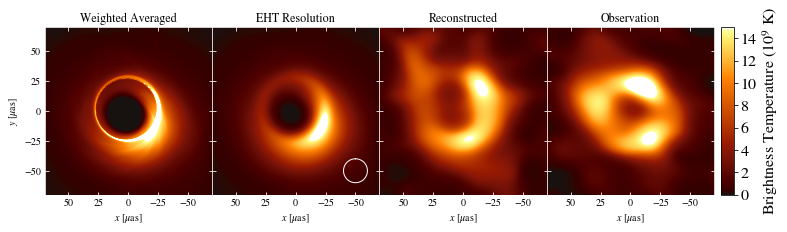

In [14]:
fig, axes = plt.subplots(1,4, figsize=(12,4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

viz.show(img_weighted,
         f=lambda img: (img * scale).to(u.K),
         ax=axes[0], cmap='afmhot_10us', vmin=0, vmax=vmax)
viz.show(img_weighted_filtered, 0,
         f=lambda img: (img * scale).to(u.K),
         ax=axes[1], cmap='afmhot_10us', vmin=0, vmax=vmax)
viz.show(img_mock,
         f=lambda img: (img * scale).to(u.K),
         ax=axes[2], cmap='afmhot_10us', vmin=0, vmax=vmax)
viz.show(img_obs,
         f=lambda img: (img * scale).to(u.K),
         ax=axes[3], cmap='afmhot_10us', vmin=0, vmax=vmax)

phi = np.linspace(0, 2*np.pi, 65)
axes[1].plot(10*np.sin(phi)-50, 10*np.cos(phi)-50, linewidth=1, color='w')

for ax in axes:
    ax.set_xlim( 70,-70)
    ax.set_ylim(-70, 70)
    ax.xaxis.set_ticks([50,25,0,-25,-50])
    ax.yaxis.set_ticks([-50,-25,0,25,50])
    ax.tick_params(
        axis='both',
        direction='in',
        top=True,
        right=True,
        color='w',
    )
    for spine in ax.spines.values():
        spine.set_edgecolor('w')
    ax.set_xlabel('$x$ [$\mu$as]')
    ax.set_ylabel(None)
axes[0].set_ylabel('$y$ [$\mu$as]')

axes[0].set_title('Weighted Averaged')
axes[1].set_title('EHT Resolution')
axes[2].set_title('Reconstructed')
axes[3].set_title('Observation')
#axes[4].axis('off')

pos = axes[3].get_position()
print(pos)

cbaxes = fig.add_axes([pos.x1+0.0075, pos.y0, 0.015, pos.y1-pos.y0])
cbar = fig.colorbar(cm.ScalarMappable(mpl.colors.Normalize(0,15), cmap='afmhot_10us'), ticks=np.arange(0, 15, 2), orientation="vertical", cax=cbaxes)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(label="Brightness Temperature ($10^9$ K)", size=16)

fig.savefig('output/bestbet_imgs_allframes.pdf', bbox_inches='tight')